In [481]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import re
import gc
import numpy as np
import math
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error,make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,BayesianRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy
import time
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [449]:
train = pd.read_csv("C:/Users/PrathikGirishShirolk/Downloads/windmill/dataset/train.csv")
test = pd.read_csv("C:/Users/PrathikGirishShirolk/Downloads/windmill/dataset/test.csv")

sample = pd.read_csv("C:/Users/PrathikGirishShirolk/Downloads/windmill/dataset/sample_submission.csv")

In [450]:
train["train"] = 1
test["train"] = 0

In [451]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

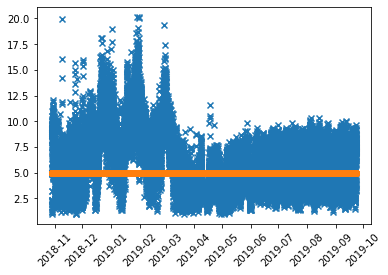

In [452]:
test["windmill_generated_power(kW/h)"] = 5
plt.scatter(train["datetime"],train["windmill_generated_power(kW/h)"],marker="x")
plt.scatter(test["datetime"],test["windmill_generated_power(kW/h)"],marker="o")
plt.xticks(rotation=45)
del test["windmill_generated_power(kW/h)"]

In [453]:
sample.head()

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,6.766521
1,WM_698,2018-11-05 10:13:20,5.966275
2,WM_39146,2019-09-14 14:03:20,2.874342
3,WM_6757,2018-12-25 15:33:20,14.851089
4,WM_21521,2019-05-04 03:13:20,3.519074


In [454]:
dataset = pd.concat([train,test]).reset_index(drop=True)

In [455]:
dataset.shape, train.shape[0]+test.shape[0]

((40286, 23), 40286)

In [456]:
train.shape, test.shape, sample.shape

((28200, 23), (12086, 22), (5, 3))

In [457]:
dataset.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),...,wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),train
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,...,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521,1
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,...,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275,1
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,...,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342,1
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,...,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089,1
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,...,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074,1


In [458]:
dataset.dtypes

tracking_id                               object
datetime                          datetime64[ns]
wind_speed(m/s)                          float64
atmospheric_temperature(°C)              float64
shaft_temperature(°C)                    float64
blades_angle(°)                          float64
gearbox_temperature(°C)                  float64
engine_temperature(°C)                   float64
motor_torque(N-m)                        float64
generator_temperature(°C)                float64
atmospheric_pressure(Pascal)             float64
area_temperature(°C)                     float64
windmill_body_temperature(°C)            float64
wind_direction(°)                        float64
resistance(ohm)                          float64
rotor_torque(N-m)                        float64
turbine_status                            object
cloud_level                               object
blade_length(m)                          float64
blade_breadth(m)                         float64
windmill_height(m)  

In [459]:
dataset["blade_area(m2)"] = dataset["blade_length(m)"] * dataset["blade_breadth(m)"]

In [460]:
"""
print(dataset.shape)
dataset["cloud_level"] = dataset["cloud_level"].replace(dataset.groupby("cloud_level")["windmill_generated_power(kW/h)"].mean().to_dict())
print(dataset.shape)
"""

'\nprint(dataset.shape)\ndataset["cloud_level"] = dataset["cloud_level"].replace(dataset.groupby("cloud_level")["windmill_generated_power(kW/h)"].mean().to_dict())\nprint(dataset.shape)\n'

In [461]:
tmp = pd.get_dummies(dataset["cloud_level"])
del dataset["cloud_level"]
print(dataset.shape)
dataset = pd.concat([dataset, tmp],axis=1)
print(dataset.shape)

(40286, 23)
(40286, 26)


In [462]:
tmp = pd.get_dummies(dataset["turbine_status"])
del dataset["turbine_status"]
print(dataset.shape)
dataset = pd.concat([dataset, tmp],axis=1)
print(dataset.shape)

(40286, 25)
(40286, 39)


In [463]:
dataset["datetime"].isnull().sum()

0

In [464]:
dataset["datetime"] = pd.to_datetime(dataset["datetime"])

dataset["month"] = dataset["datetime"].dt.month
dataset["year"] = dataset["datetime"].dt.year
dataset["day"] = dataset["datetime"].dt.day
dataset["hour"] = dataset["datetime"].dt.hour
dataset["minute"] = dataset["datetime"].dt.minute
dataset["dayofyear"] = dataset["datetime"].dt.dayofyear
dataset["dayofweek"] = dataset["datetime"].dt.dayofweek
dataset["weekofyear"] = dataset["datetime"].dt.weekofyear
dataset["quarter"] = dataset["datetime"].dt.quarter

In [465]:
dataset = dataset.sort_values('datetime').set_index('datetime')

In [466]:
#dataset["windmill_generated_power(kW/h)"].rolling("2h",min_periods=5).mean().plot()

In [467]:
#dataset["1hr_moving_average"] = dataset["windmill_generated_power(kW/h)"].rolling("2h",min_periods=5).mean()

In [468]:
dataset["generator_temp_more_than_area_temp"] = dataset["generator_temperature(°C)"] > dataset["area_temperature(°C)"]
dataset["generator_temp_more_than_area_temp"] = dataset["generator_temp_more_than_area_temp"].replace({True:1, False:0})

dataset["engine_temp_more_than_generator_temp"] = dataset["engine_temperature(°C)"] > dataset["generator_temperature(°C)"]
dataset["engine_temp_more_than_generator_temp"] = dataset["engine_temp_more_than_generator_temp"].replace({True:1, False:0})

In [469]:
#dataset["average_temperature"] = (dataset["shaft_temperature(°C)"]+dataset["gearbox_temperature(°C)"]+dataset["engine_temperature(°C)"]+dataset["generator_temperature(°C)"]+dataset["windmill_body_temperature(°C)"])/5

In [470]:
#dataset["angle_difference"] = dataset["wind_direction(°)"] - dataset["blades_angle(°)"]
#dataset["angle_difference"] = dataset["angle_difference"].abs()

In [471]:
#dataset = dataset.fillna(0)

In [472]:
dataset = dataset.fillna(dataset.mean())

In [473]:
train = dataset[dataset["train"]==1]
test = dataset[dataset["train"]==0]

In [474]:
test_order = pd.DataFrame()
test_order["id"] = test["tracking_id"]
test_order = test_order.reset_index()

In [475]:
del train["tracking_id"]
del train["train"]

del test["tracking_id"]
del test["train"]

del test["windmill_generated_power(kW/h)"]

In [476]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [477]:
X = train.loc[:, train.columns!="windmill_generated_power(kW/h)"]
y = train.loc[:, train.columns=="windmill_generated_power(kW/h)"]

In [478]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.25, random_state=1996)

Training until validation scores don't improve for 200 rounds
[200]	training's l2: 1.34258	valid_1's l2: 1.38065
[400]	training's l2: 0.437439	valid_1's l2: 0.5063
[600]	training's l2: 0.262784	valid_1's l2: 0.35479
[800]	training's l2: 0.212373	valid_1's l2: 0.319849
[1000]	training's l2: 0.189763	valid_1's l2: 0.31161
[1200]	training's l2: 0.174307	valid_1's l2: 0.308579
[1400]	training's l2: 0.163417	valid_1's l2: 0.306815
[1600]	training's l2: 0.154099	valid_1's l2: 0.305403
[1800]	training's l2: 0.14605	valid_1's l2: 0.304281
[2000]	training's l2: 0.13836	valid_1's l2: 0.303126
[2200]	training's l2: 0.131116	valid_1's l2: 0.302747
Early stopping, best iteration is:
[2188]	training's l2: 0.131547	valid_1's l2: 0.302721
R^2 is: 0.9580561847925203
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 1.34553	valid_1's l2: 1.42087
[400]	training's l2: 0.430409	valid_1's l2: 0.544508
[600]	training's l2: 0.255881	valid_1's l2: 0.387029
[800]	training's l2: 

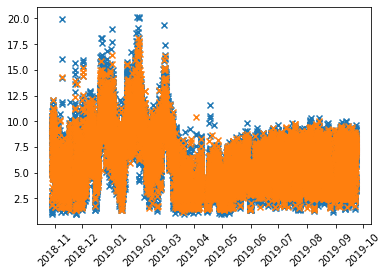

In [479]:
y_pred_tot=[]
err=[]
feature_importance_df = pd.DataFrame()

#For Stacking
lgbm_train_res = pd.DataFrame()
lgbm_test_res = pd.DataFrame()

from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=3,shuffle=True,random_state=1996)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index, :], y.loc[test_index, :]
    
    depth=8
    m=LGBMRegressor(n_estimators=6000,
                    n_jobs=-1,
                    learning_rate=0.005,
                    max_depth=depth,
                    num_leaves=2**depth-1,
                    reg_alpha = 0.5,
                    reg_lambda = 0.5)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=200,eval_metric="r2")
    preds=m.predict(X_test,num_iteration=m.best_iteration_)
    #print(f"RMSLE is:",rmsle_lgb(y_test, preds))
    print(f"R^2 is: {r2_score(y_test, preds)}")
    err.append(r2_score(y_test, preds))
    p = m.predict(test)
    y_pred_tot.append(p)
    
    lgbm_train_res["iteration_"+str(i)] = m.predict(X)
    lgbm_test_res["iteration_"+str(i)] = m.predict(test)
    i=i+1

timestamp = time.time()
prefix = "firsttry_r2_8depth_6000n_005lr_pt5alpha_pt5lambda_addedMinFeature_missingValWithAvg"

lgbm_train_res.to_csv("./preds/"+prefix+"_"+str(timestamp)+"_train.csv")
lgbm_test_res.to_csv("./preds/"+prefix+"_"+str(timestamp)+"_test.csv")

submission = pd.DataFrame()
t_train = pd.read_csv("C:/Users/PrathikGirishShirolk/Downloads/windmill/dataset/train.csv")
t_test = pd.read_csv("C:/Users/PrathikGirishShirolk/Downloads/windmill/dataset/test.csv")
submission[["tracking_id","datetime"]] = test_order[["id","datetime"]]
submission["windmill_generated_power(kW/h)"] = lgbm_test_res.mean(axis=1)
submission.to_csv("./submission/"+prefix+"_"+str(timestamp)+"_train.csv")

t_train["datetime"] = pd.to_datetime(t_train["datetime"])
plt.scatter(t_train["datetime"], t_train["windmill_generated_power(kW/h)"], marker="x")
plt.xticks(rotation=45)

submission["datetime"] = pd.to_datetime(submission["datetime"])
plt.scatter(submission["datetime"], submission["windmill_generated_power(kW/h)"], marker="x")
plt.xticks(rotation=45)
plt.show()

In [ ]:
[1975]	training's l2: 0.0945204	valid_1's l2: 0.303972
R^2 is: 0.9578829553824462

In [22]:
depth = 10
m=LGBMRegressor(n_estimators=2000,
                n_jobs=-1,
                learning_rate=0.005,
                max_depth=depth,
                num_leaves=2**depth-1)
distributions = dict(reg_alpha = [0.5,1,3,5,7,10],
                     reg_lambda = [0.5,1,3,5,7,10])
clf = RandomizedSearchCV(m, distributions, random_state=1996, verbose=200)
search = clf.fit(X, y)
search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] reg_lambda=0.5, reg_alpha=5 .....................................
[CV] ......... reg_lambda=0.5, reg_alpha=5, score=0.914, total=  40.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.5s remaining:    0.0s
[CV] reg_lambda=0.5, reg_alpha=5 .....................................
[CV] ......... reg_lambda=0.5, reg_alpha=5, score=0.916, total=  40.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[CV] reg_lambda=0.5, reg_alpha=5 .....................................
[CV] ......... reg_lambda=0.5, reg_alpha=5, score=0.916, total=  32.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s
[CV] reg_lambda=0.5, reg_alpha=5 .....................................
[CV] ......... reg_lambda=0.5, reg_alpha=5, score=0.919, total=  33.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] .......... reg_lambda=10, reg_alpha=3, score=0.916, total=  32.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 20.8min remaining:    0.0s
[CV] reg_lambda=10, reg_alpha=3 ......................................
[CV] .......... reg_lambda=10, reg_alpha=3, score=0.916, total=  31.7s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 21.4min remaining:    0.0s
[CV] reg_lambda=10, reg_alpha=3 ......................................
[CV] .......... reg_lambda=10, reg_alpha=3, score=0.919, total=  31.5s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 21.9min remaining:    0.0s
[CV] reg_lambda=10, reg_alpha=3 ......................................
[CV] .......... reg_lambda=10, reg_alpha=3, score=0.918, total=  31.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 22.4min remaining:    0.0s
[CV] reg_lambda=7, reg_alpha=7 .......................................
[CV] ........... reg_lambda=7, reg_alpha=7, score=0.914, total=  30.0s
[Parallel(n_jobs=1)]: Done  41 out of  41

{'reg_lambda': 0.5, 'reg_alpha': 10}

In [368]:
import glob

files = glob.glob("C:\\Users\\PrathikGirishShirolk\\Downloads\\windmill\\submission\\*")

subs = pd.read_csv(files[0])
del subs["Unnamed: 0"]

for file_path in files[1:]:
    t_subs = pd.read_csv(file_path)
    del t_subs["Unnamed: 0"]
    subs = pd.merge(subs, t_subs, how='inner', on=["tracking_id","datetime"])
subs

,tracking_id,datetime,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,...,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y,windmill_generated_power(kW/h)_x,windmill_generated_power(kW/h)_y
0,WM_19817,2019-04-17 08:53:20,2.605560,2.495227,2.464523,2.464523,2.504785,2.463608,2.477208,2.494860,...,2.780903,2.466991,2.428585,2.495227,2.516349,2.495227,2.469693,2.436596,2.431810,2.467744
1,WM_18723,2019-03-30 07:43:20,2.444375,2.362535,2.371887,2.371887,2.375015,2.361942,2.393687,2.478971,...,2.653995,2.543149,2.487711,2.362535,2.426851,2.362535,2.430192,2.427538,2.423319,2.398362
2,WM_34552,2019-08-10 11:33:20,3.264769,3.294864,3.375252,3.375252,3.307383,3.396951,3.372419,3.297305,...,3.385620,3.350628,3.305236,3.294864,3.320772,3.294864,3.086727,3.132010,3.145340,3.347657
3,WM_28570,2019-06-26 03:53:20,6.576924,6.477231,6.620039,6.620039,6.450849,6.598830,6.598907,6.284266,...,6.733469,6.517075,5.752114,6.477231,6.119641,6.477231,7.058062,7.111440,7.147623,6.521121
4,WM_36934,2019-08-27 16:43:20,3.562834,3.528699,3.538069,3.538069,3.533845,3.522407,3.486635,3.508625,...,3.703819,3.625053,3.541186,3.528699,3.466381,3.528699,3.813593,3.765381,3.742080,3.497757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,6.602788,6.538066,6.546056,6.546056,6.528754,6.482171,6.507943,6.500564,...,6.590824,6.563305,6.458347,6.538066,6.486080,6.538066,6.654872,6.641057,6.631386,6.508909
12082,WM_1630,2018-11-12 17:33:20,3.320667,3.244624,3.300613,3.300613,3.269010,3.286697,3.257108,3.300216,...,3.290112,3.242688,3.220741,3.244624,3.189944,3.244624,3.256162,3.225911,3.209849,3.280855
12083,WM_24703,2019-05-27 11:53:20,5.122170,4.991144,5.091895,5.091895,5.019483,5.076701,5.060866,4.939567,...,5.183152,4.945267,4.944314,4.991144,4.933221,4.991144,5.051838,5.003205,4.975927,5.056226
12084,WM_22893,2019-05-13 21:53:20,5.403904,5.453740,5.424489,5.424489,5.453674,5.415688,5.428389,5.417443,...,5.537003,5.464156,5.424285,5.453740,5.456892,5.453740,5.285723,5.307385,5.321643,5.426365


In [388]:
final = pd.DataFrame()
final["tracking_id"] = subs["tracking_id"]
final["datetime"] = subs["datetime"]
final["windmill_generated_power(kW/h)_x"] = subs.loc[:, [i for i in subs.columns if i not in ['tracking_id', 'datetime']]].max(axis=1)

In [389]:
final = final.rename(columns={"windmill_generated_power(kW/h)_x":"windmill_generated_power(kW/h)"})

In [390]:
final.to_csv("all_submission_max_16th_May_11_23_pm.csv")